## Фреймворк PyTorch для разработки искусственных нейронных сетей
### Урок 3. Generative adversarial networks (GAN): генеративные сети

In [139]:
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:77% !important; }</style>"))

In [140]:
import os
import numpy as np
import pandas as pd
import math

from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision.transforms as transforms
import torchvision
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

########### Вывод изображений и сохранение ################################
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
from torchvision.utils import save_image, make_grid

In [141]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

In [142]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


**1. Как было сказано ранее, GAN обучается воспроизводить реальные данные. Поэтому Вам предлагается обучить генератор создавать точки, которые будут лежать на графике функции $y = \frac{sin(x)}{x} - \frac{x}{10}$. При выполненинии данного задания структура GAN остается той же, но Вам нужно:**
 * Сгенерировать настоящие данные
 * Изменить архитектуру дискриминатора и генератора
 * Без графиков домашку не принимаю

In [5]:
# Функция linspace() возвращает одномерный массив из указанного количества элементов, значения которых равномерно распределенны внутри заданного интервала.
x = np.linspace(1, 30, 1000)
def func_y(x):
    return np.sin(x)/x - x/10
# print("Func_y:", func_y(x))    

In [6]:
dataset = func_y(x)

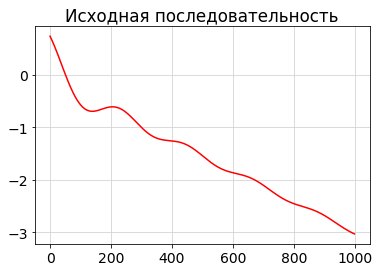

In [7]:
plt.plot(dataset, 'r')

plt.grid(color="lightgrey")
plt.title('Исходная последовательность' )
plt.show()

### Preparing the Training Data

In [8]:
class build_dataset(Dataset):
    def __init__(self, d_border, u_border, point_number):
        x = np.linspace(d_border, u_border, point_number)
        if 0 in x:
            x[x == 0] = 0.00001
        self.data = x
        self.labels = np.sin(x)/x - x/10


    def __len__(self):
        return len(self.data) 
    
    
    def __getitem__(self, idx):
        item = self.data[idx]
        label = self.labels[idx]
        return (item, label)

In [9]:
dataset = build_dataset(1, 30, 1000)

In [10]:
batch_size = 16

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(0.75*len(dataset)),
                                                                      len(dataset) - int(0.75*len(dataset))])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=True)

### Implementing the Discriminator

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [12]:
discriminator = Discriminator().to(device)

### Implementing the Generator

In [13]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [14]:
generator = Generator().to(device)

### Training the Models

In [15]:
lr = 0.0001

b1 = 0.5
b2 = 0.999

sample_interval = 50

loss_function = nn.BCELoss()

In [16]:
# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

In [17]:
d_loss_history = []
g_loss_history = []

In [18]:
idx = torch.randperm(16)
idx

tensor([ 3,  2, 13,  4, 10, 14,  0,  9, 12,  1, 15,  6,  7,  8,  5, 11])

In [19]:
for epoch in range(1):
    for i, (number, labels) in enumerate(train_loader):

##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########

        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        real_number = Variable(number.type(torch.FloatTensor)).to(device)

        #генерация шума
        idx = torch.randperm(batch_size)
        z = Variable(number[idx].type(torch.FloatTensor)).to(device)

        print(f"real_number: {real_number}")
        # print(f"{z.shape}")
        print(f"z: {z.view(16, 1)}")
        print(f"{z.view(16, 1).shape}")
        # print(f"z: {z}")
        # print(f"real_number + z: {real_number + z}")
        print(f"valid.shape: {valid.shape}")
        print(f"fake.shape: {fake.shape}")

        break
    break

real_number: tensor([28.7227, 19.2012, 19.7528, 15.6306, 10.2603, 16.0080, 26.0521,  2.4224,
         7.0090, 20.8268,  5.3253, 29.2452, 14.0340, 13.2502, 22.3363,  7.9960],
       device='cuda:0')
z: tensor([[ 5.3253],
        [15.6306],
        [14.0340],
        [19.2012],
        [ 7.0090],
        [20.8268],
        [13.2502],
        [22.3363],
        [28.7227],
        [16.0080],
        [ 2.4224],
        [26.0521],
        [ 7.9960],
        [19.7528],
        [10.2603],
        [29.2452]], device='cuda:0')
torch.Size([16, 1])
valid.shape: torch.Size([16, 1])
fake.shape: torch.Size([16, 1])


[Epoch 498/500] [Batch 44/47] [D loss: 0.732361] [G loss: 0.689015]


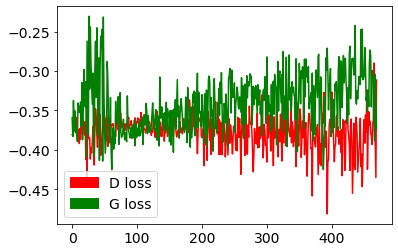

In [20]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')

g_loss_p = 1000
ep_loss = 0
n_epochs = 500

for epoch in range(n_epochs):
    for i, (number, labels) in enumerate(train_loader):

##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########

        valid = Variable(torch.FloatTensor(len(number), 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(len(labels), 1).fill_(0.0), requires_grad=False).to(device)
#         valid = valid.detach().numpy()

        real_numbers = Variable(number.type(torch.FloatTensor)).to(device)

######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        idx = torch.randperm(len(number))
        z = Variable(number[idx].type(torch.FloatTensor)).to(device)

        gen_numbers = generator(z.view(len(z), 1))

        validity = discriminator(gen_numbers)
        g_loss = loss_function(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()

        if g_loss < g_loss_p:
            torch.save(generator.state_dict(), "series_gan_loss_min.pth")
            g_loss_p = g_loss
            ep_loss = epoch

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator(labels.view(len(labels), 1).type(torch.FloatTensor).to(device))
        d_real_loss = loss_function(real_pred, valid)

        fake_pred = discriminator(gen_numbers.detach())
        d_fake_loss = loss_function(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############

        batches_done = epoch * len(train_loader) + i
    
        if batches_done % sample_interval == 0:
            plt.clf()
            
            display.clear_output(wait=False)
            # sample_image(gen_imgs)
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(train_loader), d_loss.item(), g_loss.item()) ) 
            
            # display.display(plt.gcf())

            d_loss_history.append(d_loss)
            g_loss_history.append(g_loss)

            plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
            plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
            plt.legend(handles=[red_patch, green_patch])
            plt.show()

In [21]:
torch.save(generator.state_dict(), "series_gan.pth")

In [22]:
generator_r = Generator().to(device)
generator_r.load_state_dict(torch.load("series_gan_loss_min.pth"))

<All keys matched successfully>

In [23]:
x =  np.linspace(1, 30, 1000)
xt = torch.from_numpy(x).type(torch.FloatTensor).to(device)
xt.type()

'torch.cuda.FloatTensor'

In [24]:
gen_numbers = generator_r(xt.view(len(x), 1))

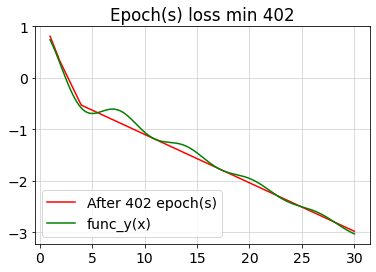

In [25]:
plt.plot(x, gen_numbers.detach().cpu().numpy(), 'r', label=f"After {ep_loss} epoch(s)")
plt.plot(x, func_y(x), 'g', label=f"func_y(x)")

plt.legend(loc="lower left")
plt.grid(color="lightgrey")
plt.title(f'Epoch(s) min loss {ep_loss}')
plt.show()

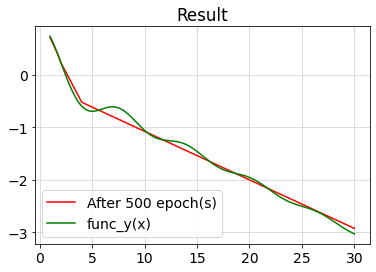

In [26]:
generator_f = Generator().to(device)
generator_f.load_state_dict(torch.load("series_gan.pth"))

gen_numbers_f = generator_f(xt.view(len(x), 1))

plt.plot(x, gen_numbers_f.detach().cpu().numpy(), 'r', label=f"After {n_epochs} epoch(s)")
plt.plot(x, func_y(x), 'g', label=f"func_y(x)")

plt.legend(loc="lower left")
plt.grid(color="lightgrey")
plt.title('Result' )
plt.show()

In [27]:
x_test = []
y_test = []

for x, y in test_loader:
    x_test.append(x), y_test.append(y)

In [28]:
xt = torch.FloatTensor(x_test).to(device)
gen_numbers_t = generator_f(xt.view(len(x_test), 1))

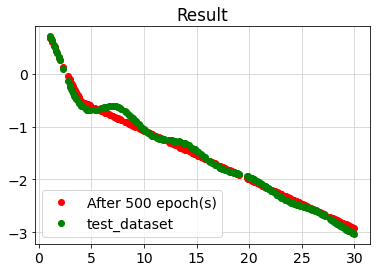

In [29]:
plt.plot(x_test, gen_numbers_t.detach().cpu().numpy(), 'ro', label=f"After {n_epochs} epoch(s)")
plt.plot(x_test, y_test, 'go', label=f"test_dataset")

plt.legend(loc="lower left")
plt.grid(color="lightgrey")
plt.title('Result' )
plt.show()

**2. Изменить используемые модели генератора и дискриминатора, с помощью сверточных слоев. Идея: https://arxiv.org/abs/1511.06434 Датасет можно использовать так же MNIST.**

In [30]:
import urllib

basepath = './MNIST/raw/'


def set_header_for(url, filename):
    opener = urllib.request.URLopener()
    opener.addheader('User-Agent', 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) '
                         'Chrome/80.0.3987.132 Safari/537.36',)
    opener.retrieve(
    url, f'{basepath}/{filename}')

set_header_for('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', 'train-images-idx3-ubyte.gz')
set_header_for('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', 'train-labels-idx1-ubyte.gz')
set_header_for('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', 't10k-images-idx3-ubyte.gz')
set_header_for('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: URLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: URLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: URLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: URLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  app.launch_new_instance()


### Preparing the Training Data

transforms.ToTensor() преобразует данные в тензор PyTorch.  
transforms.Normalize() преобразует диапазон тензорных коэффициентов.  
Исходные коэффициенты, заданные функцией transforms.ToTensor(), находятся в диапазоне от 0 до 1. Поскольку изображения имеют черный фон, большинство коэффициентов равны 0.  
Функция transforms.Normalize() изменяет диапазон коэффициентов на [−1,1][−1,1], вычитая 0.5 из исходных коэффициентов и деля результат на 0.5. Преобразование сокращает количество элементов входных выборок, равных 0. Это помогает в обучении моделей.

In [111]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

In [112]:
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

In [113]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

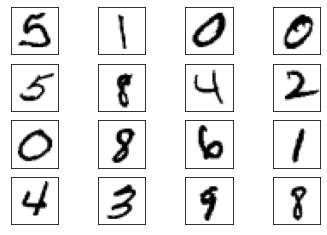

In [114]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

### Implementing the Discriminator and the Generator

In [115]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [116]:
discriminator = Discriminator().to(device)

In [117]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

In [118]:
generator = Generator().to(device)

### Training the Models

In [119]:
lr = 0.0001
n_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [120]:
for epoch in range(n_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device)
        real_samples_labels = torch.ones((batch_size, 1)).to(device)
        latent_space_samples = torch.randn((batch_size, 100)).to(device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device)
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(device)

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.5867264270782471
Epoch: 0 Loss G.: 0.4573841094970703
Epoch: 1 Loss D.: 0.05532001331448555
Epoch: 1 Loss G.: 3.993964195251465
Epoch: 2 Loss D.: 0.10524097830057144
Epoch: 2 Loss G.: 4.316934108734131
Epoch: 3 Loss D.: 0.09344257414340973
Epoch: 3 Loss G.: 3.7912957668304443
Epoch: 4 Loss D.: 0.04626034200191498
Epoch: 4 Loss G.: 5.228184700012207
Epoch: 5 Loss D.: 0.06593401730060577
Epoch: 5 Loss G.: 3.972043037414551
Epoch: 6 Loss D.: 0.12809644639492035
Epoch: 6 Loss G.: 2.786487102508545
Epoch: 7 Loss D.: 0.17543403804302216
Epoch: 7 Loss G.: 2.4498190879821777
Epoch: 8 Loss D.: 0.27102193236351013
Epoch: 8 Loss G.: 2.7699880599975586
Epoch: 9 Loss D.: 0.2196589857339859
Epoch: 9 Loss G.: 2.359185218811035
Epoch: 10 Loss D.: 0.3306375741958618
Epoch: 10 Loss G.: 2.0830235481262207
Epoch: 11 Loss D.: 0.2673860788345337
Epoch: 11 Loss G.: 2.285313606262207
Epoch: 12 Loss D.: 0.27296388149261475
Epoch: 12 Loss G.: 2.1470227241516113
Epoch: 13 Loss D.: 0.224301695

### Checking the Samples Generated by the GAN

In [123]:
latent_space_samples = torch.randn(batch_size, 100).to(device)
generated_samples = generator(latent_space_samples)

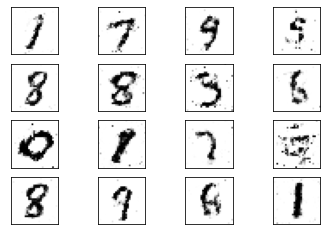

In [124]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

## Alternative option

In [143]:
import itertools

import subprocess
import os

### Discriminator Model

In [144]:
class Discriminator(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        
        self.hidden_0 = nn.Sequential( 
            nn.Linear(in_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
        )
        self.hidden_1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4)
        )
        self.hidden_2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, out_features),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden_0(x)
        x = self.hidden_1(x)
        x = self.hidden_2(x)
        x = self.out(x)
        return x

### Generator Model

In [145]:
class Generator(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()

        self.hidden_0 = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        self.hidden_1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU()
        )
        self.hidden_2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        self.out = nn.Sequential(
            nn.Linear(1024, out_features),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden_0(x)
        x = self.hidden_1(x)
        x = self.hidden_2(x)
        x = self.out(x)
        return x

### Helper Methods

<li>noise helps us generate noise input data for generator</li>
<li>im_convert helps us visualize Tensor image with matplotlib</li>

In [146]:
def noise(data_size):
    '''
    Generates data_size number of random noise
    '''
    noise_features = 100
    n = torch.randn(data_size, noise_features)
    return n

def im_convert(tensor):
    '''
        Convert Tensor to displable format
    '''
    image = tensor.to("cpu").clone().detach()
    image = image.numpy()
    image = image.transpose(1,2,0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)

    return image

### Load Training Dataset

In [147]:
# Loading training dataset
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,)),
    ])

dataset = datasets.MNIST(root='', train=True, 
                        transform=transforms, download=True)
dataloader = DataLoader(dataset, batch_size=128, 
                        drop_last=True,
                        shuffle=True)

### Load Models

In [148]:
# Loading models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create discriminator and generator
discriminator = Discriminator(in_features=784, out_features=1).to(device)
generator = Generator(in_features=100, out_features=784).to(device)

# Create 100 test_noise for visualizing how well our model perform.
test_noise = noise(100).to(device)

### Optimizer and Loss

In [149]:
# Optimizers and loss
lr = 0.0002
optimizerD = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
criterion = nn.BCELoss()

### True/False labels

In [150]:
# True and False Labels.  128 is the batch size
true_label = torch.ones(128, 1).to(device)
false_label = torch.zeros(128, 1).to(device)

### Create a folder for saving the result

In [151]:
# Create folder to hold result
result_folder = 'gan1-result'
if not os.path.exists(result_folder ):
    os.makedirs(result_folder )

### Training in action

In [152]:
# Training in action
print("Starting Training...")

num_epochs = 50
discriminator_loss_history = []
generator_loss_history = []

for epoch in range(1, num_epochs+1):
    discriminator_batch_loss = 0.0
    generator_batch_loss = 0.0
    for batch_idx, (data, targets) in enumerate(dataloader):
        data = data.to(device)
        batch_size = data.shape[0]

        discriminator.zero_grad()

        # Train discriminator to get better at differentiate real/fake data
        # 1.1 Train discriminator on real data
        d_real_predict = discriminator(data.view(data.shape[0], -1))
        d_real_loss = criterion(d_real_predict, true_label)
  

        # 1.2 Train discriminator on fake data from generator
        d_fake_noise = noise(batch_size).to(device)
        # Generate outputs and detach to avoid training the Generator on these labels
        d_fake_input = generator(d_fake_noise).detach()
        d_fake_predict = discriminator(d_fake_input)
        d_fake_loss = criterion(d_fake_predict, false_label)

        # 1.3 combine real loss and fake loss for discriminator
        discriminator_loss = d_real_loss + d_fake_loss
        discriminator_batch_loss += discriminator_loss.item()
        discriminator_loss.backward()
        optimizerD.step()


        # Train generator to get better at deceiving discriminator
        g_fake_noise = noise(batch_size).to(device)
        g_fake_input = generator(g_fake_noise)
        generator.zero_grad()
        # Get prediction from discriminator
        g_fake_predict = discriminator(g_fake_input)
        generator_loss = criterion(g_fake_predict, true_label)
        generator_batch_loss += generator_loss.item()
        generator_loss.backward()
        optimizerG.step()

        # print loss every 100 batches
        if (batch_idx + 1) % 100 == 0:

            print(f'Epoch [{epoch}/{num_epochs}]  Batch {batch_idx + 1}/{len(dataloader)} \
                    Loss D: {discriminator_loss:.4f}, Loss G: {generator_loss:.4f}')


    discriminator_loss_history.append(discriminator_batch_loss / (batch_idx + 1))
    generator_loss_history.append(generator_batch_loss / (batch_idx + 1))

    with torch.no_grad():
        
        fake_images = generator(test_noise)

        size_figure_grid = 10
        fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
        for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
            ax[i, j].get_xaxis().set_visible(False)
            ax[i, j].get_yaxis().set_visible(False)

        for k in range(10*10):
            i = k // 10
            j = k % 10
            ax[i, j].cla()
            ax[i, j].imshow(im_convert(fake_images[k].view(1,28,28)))

        label = 'Epoch {0}'.format(epoch)
        fig.text(0.5, 0.04, label, ha='center')
        plt.savefig(result_folder + "/gan%03d.png" % epoch)
        plt.show(block=False)
        plt.pause(1.5)
        plt.close(fig)

Output hidden; open in https://colab.research.google.com to view.

### Generate gif output

In [153]:
# create gif, 2 frames per second
subprocess.call([
    'ffmpeg', '-framerate', '2', '-i', \
    result_folder + '/gan%03d.png', result_folder+'/output.gif'
])

0

### Display Loss History

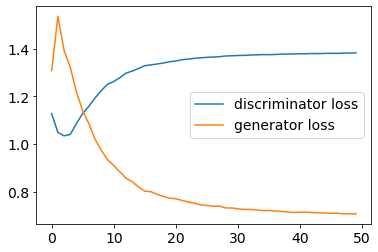

In [154]:
# plot discriminator and generator loss history
# clear figure
plt.clf()
plt.plot(discriminator_loss_history, label='discriminator loss')
plt.plot(generator_loss_history, label='generator loss')
plt.savefig(result_folder + "/loss-history.png")
plt.legend()
plt.show()